In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

filename = "AMAZON_FASHION_5.json"

df = pd.read_json(path_or_buf=filename, lines=True)




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/shy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
df['asin'].value_counts()

B009MA34NY    377
B0092UF54A    376
B010RRWKT4    376
B005AGO4LU    376
B014IBJKNO    375
B0014F7B98    374
B0058YEJ5K    367
B001IKJOLW    365
B000YFSR5G     56
B000YFSR4W     36
B000K2PJ4K     10
B0017LD0BM     10
B0017LGD34     10
B00RLSCLJM      9
B0014F8TIU      8
B00G8Q7JZ4      8
B001LNSY2Q      7
B000V0IBDM      7
B000KPIHQ4      7
B0014HA6VG      4
B00I0VHS10      4
B0012DR1LU      4
B00ND9047Y      2
B01H7KY678      1
B016XAJLVO      1
B01595OS62      1
B00MLYE8PQ      1
B00ZUA6AJK      1
B00LKWYX2I      1
B00GKF5BAS      1
B003M6060S      1
Name: asin, dtype: int64

In [4]:
list(df[df['asin'] == 'B009MA34NY']['reviewText'])

['I always get a half size up in my tennis shoes. For some reason these feel to big in the heel area and wide.',
 'Put them on and walked 3 hours with no problem! Love them! So light feeling',
 'excelente',
 'The shoes fit well in the arch area. They are a little wider in the toe area of the shoe, you feel like you have a lot of room. This does not make the shoe uncomfortable, just had to get used to it. Love the shoe.',
 "Tried them on in a store before buying online so I knew they'd fit good. Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far. They are really light and comfortable. Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc. Highly satisfied with this purchase.",
 'I recommend that!',
 "My son likes these, and this is the 2nd pair he's worn.",
 'Comfortable',
 'Fit fine...did not like color in person',
 'The shoe is to

In [6]:
import json

#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
with open(filename) as f:
    reviews_json = f.readlines()

reviews = []
for review_json in reviews_json:
    review = json.loads(review_json)
    if "overall" in review and "reviewText" in review:
        reviews.append(
            {
                "rating": review["overall"],
                "title": review["summary"],
                "text": review["reviewText"],
            }
        )

#df = pd.DataFrame.from_dict(reviews)

In [8]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
#import sklearn.decomposition

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [10]:
#preprocessing
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

#credit to Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = " ".join(_sample)
  return data_samples

data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)

In [11]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.03, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(375, 343)


In [159]:
len(data_samples)

375

In [12]:
print(len(tfidf_vectorizer.stop_words_))
tfidf_vectorizer.stop_words_

563


{'000',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'achilles',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'anymore',
 'apart',
 'arch',
 'arose',
 'artculo',
 'asics',
 'attention',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'big',
 'blood',
 'bluff',
 'bootcamps',
 'bought',
 'boxier',
 'breath',
 'breathe',
 'breathes',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'care',
 'careful',
 'carpet',
 'carpeted',
 'certain',
 'certainly',
 'cheap',
 'check',
 'chic',
 'christmas',
 'circulation',
 'cl',
 'class',
 'cleaning',
 'client',
 'clorox',
 'close',
 'closer',
 'closet',
 'clothes',
 'coach',
 'color',
 'colors',
 'colour',
 'come'

In [51]:
tfidf_vectorizer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [13]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


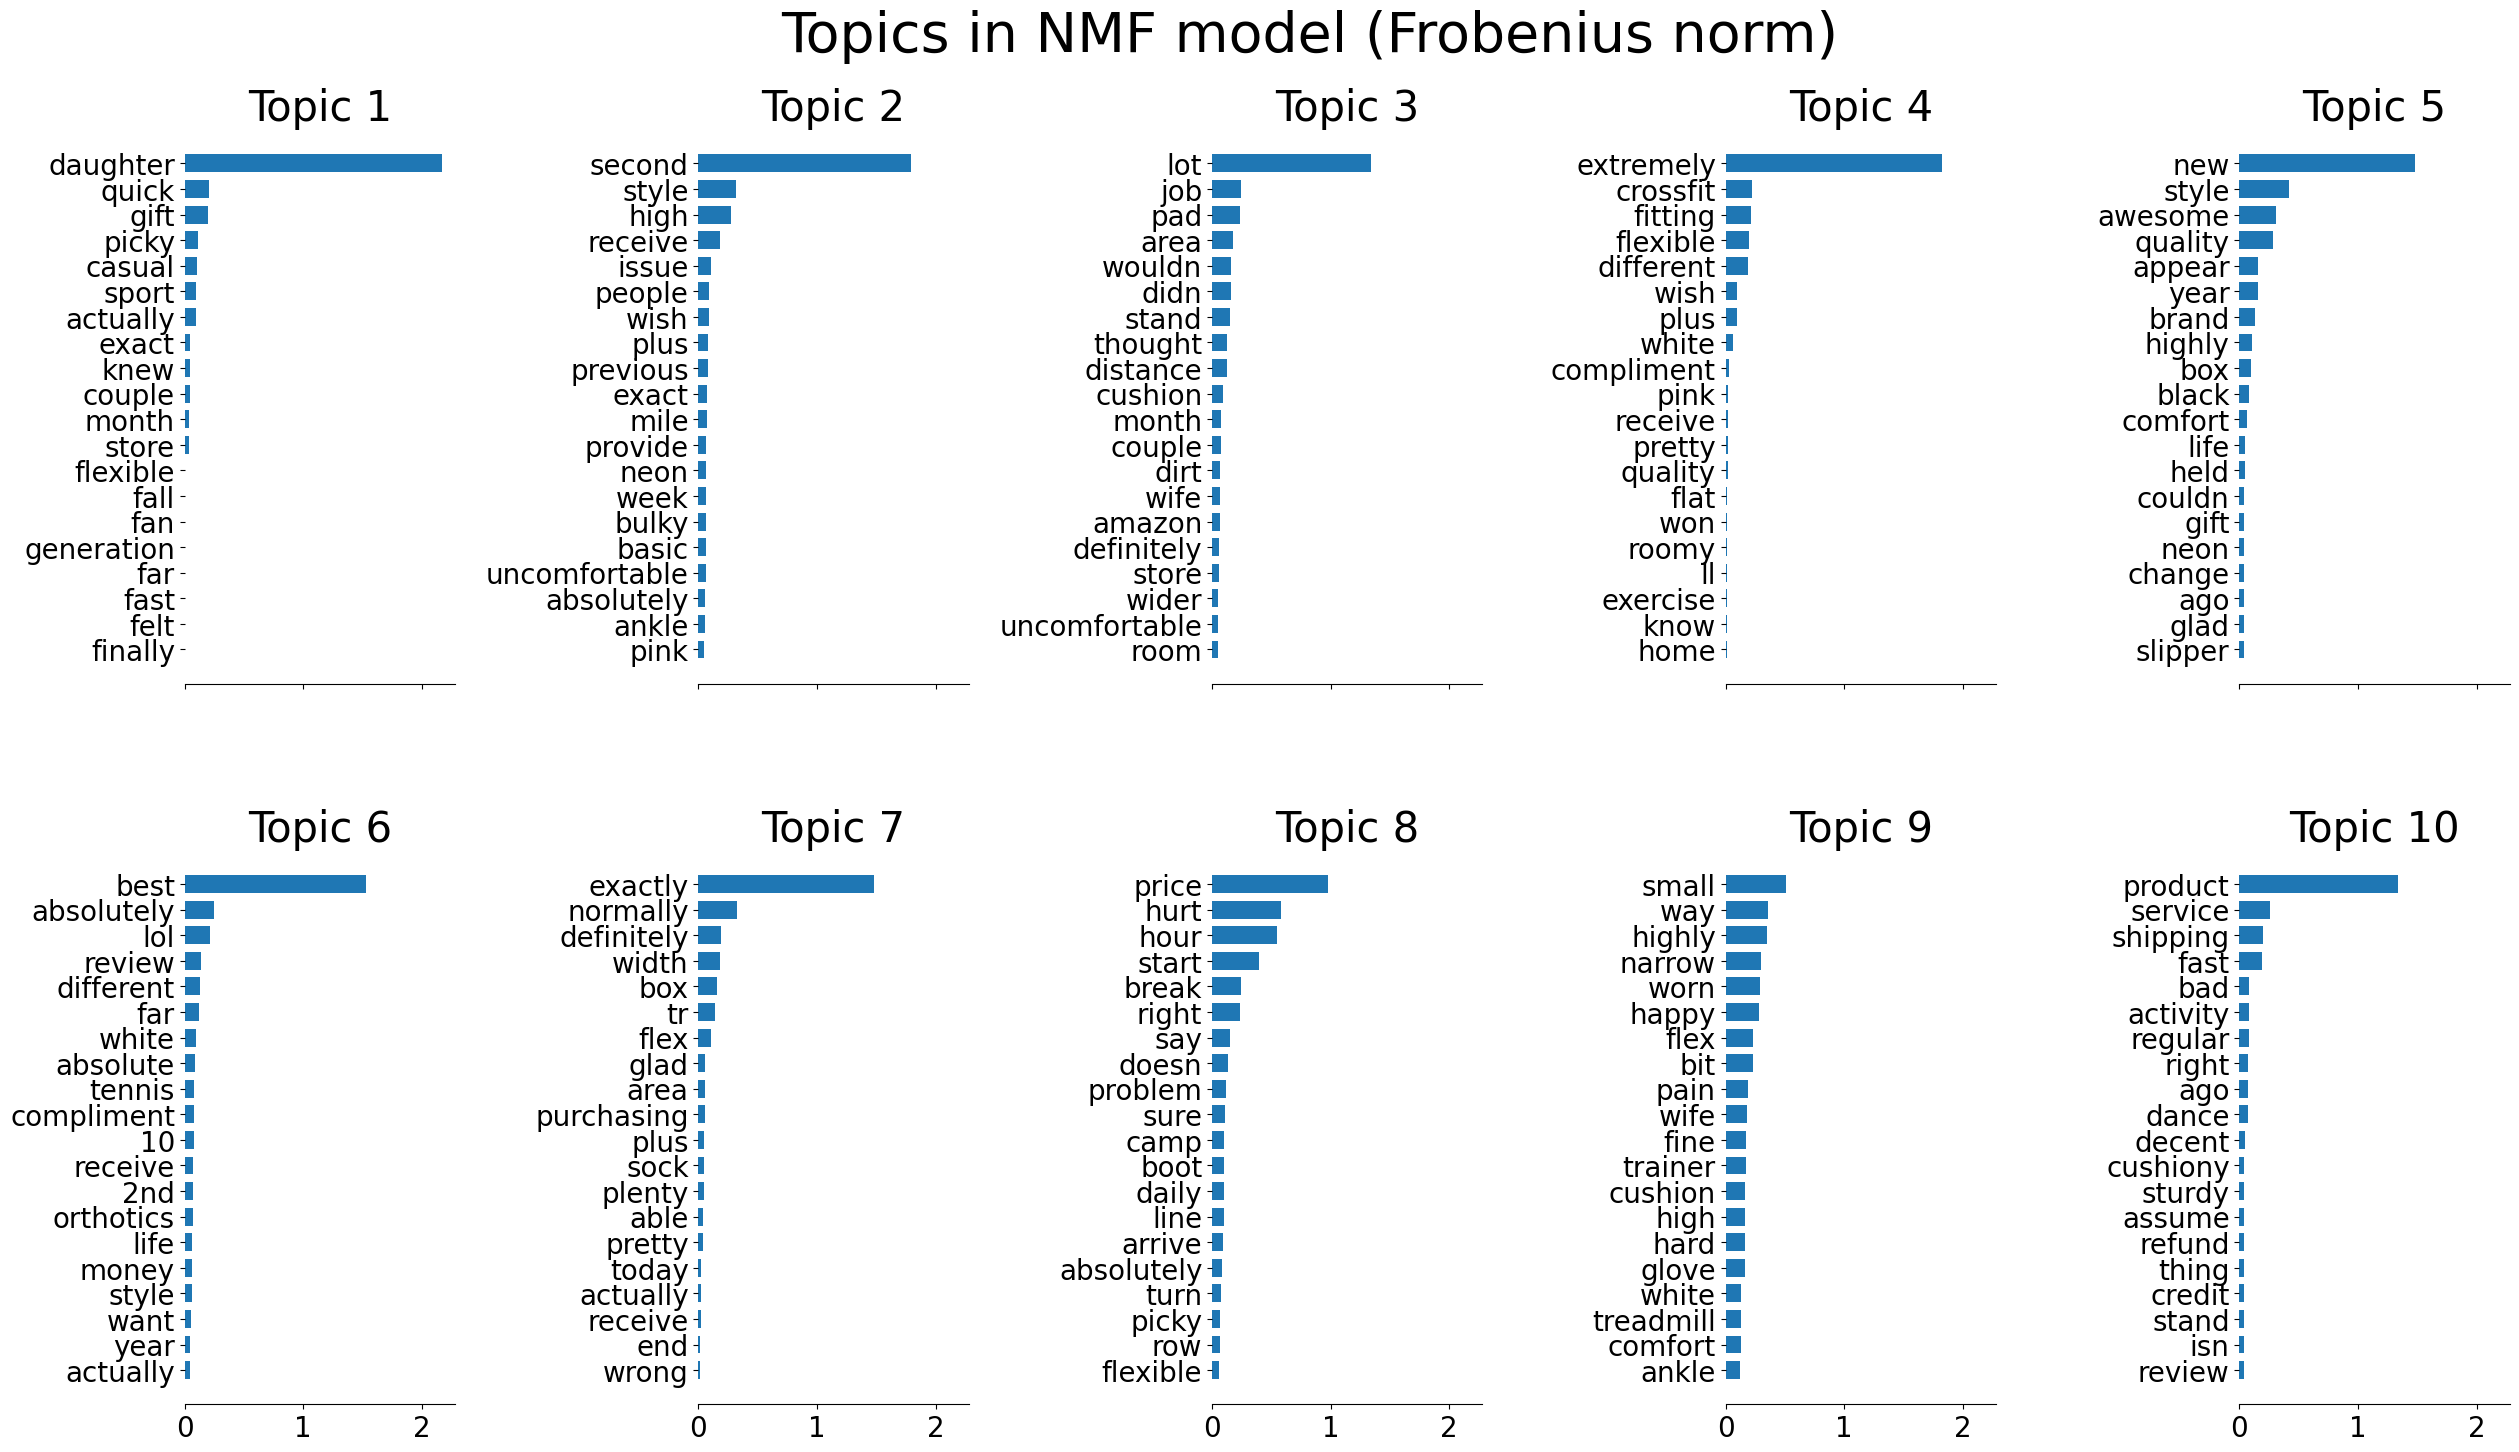

In [14]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

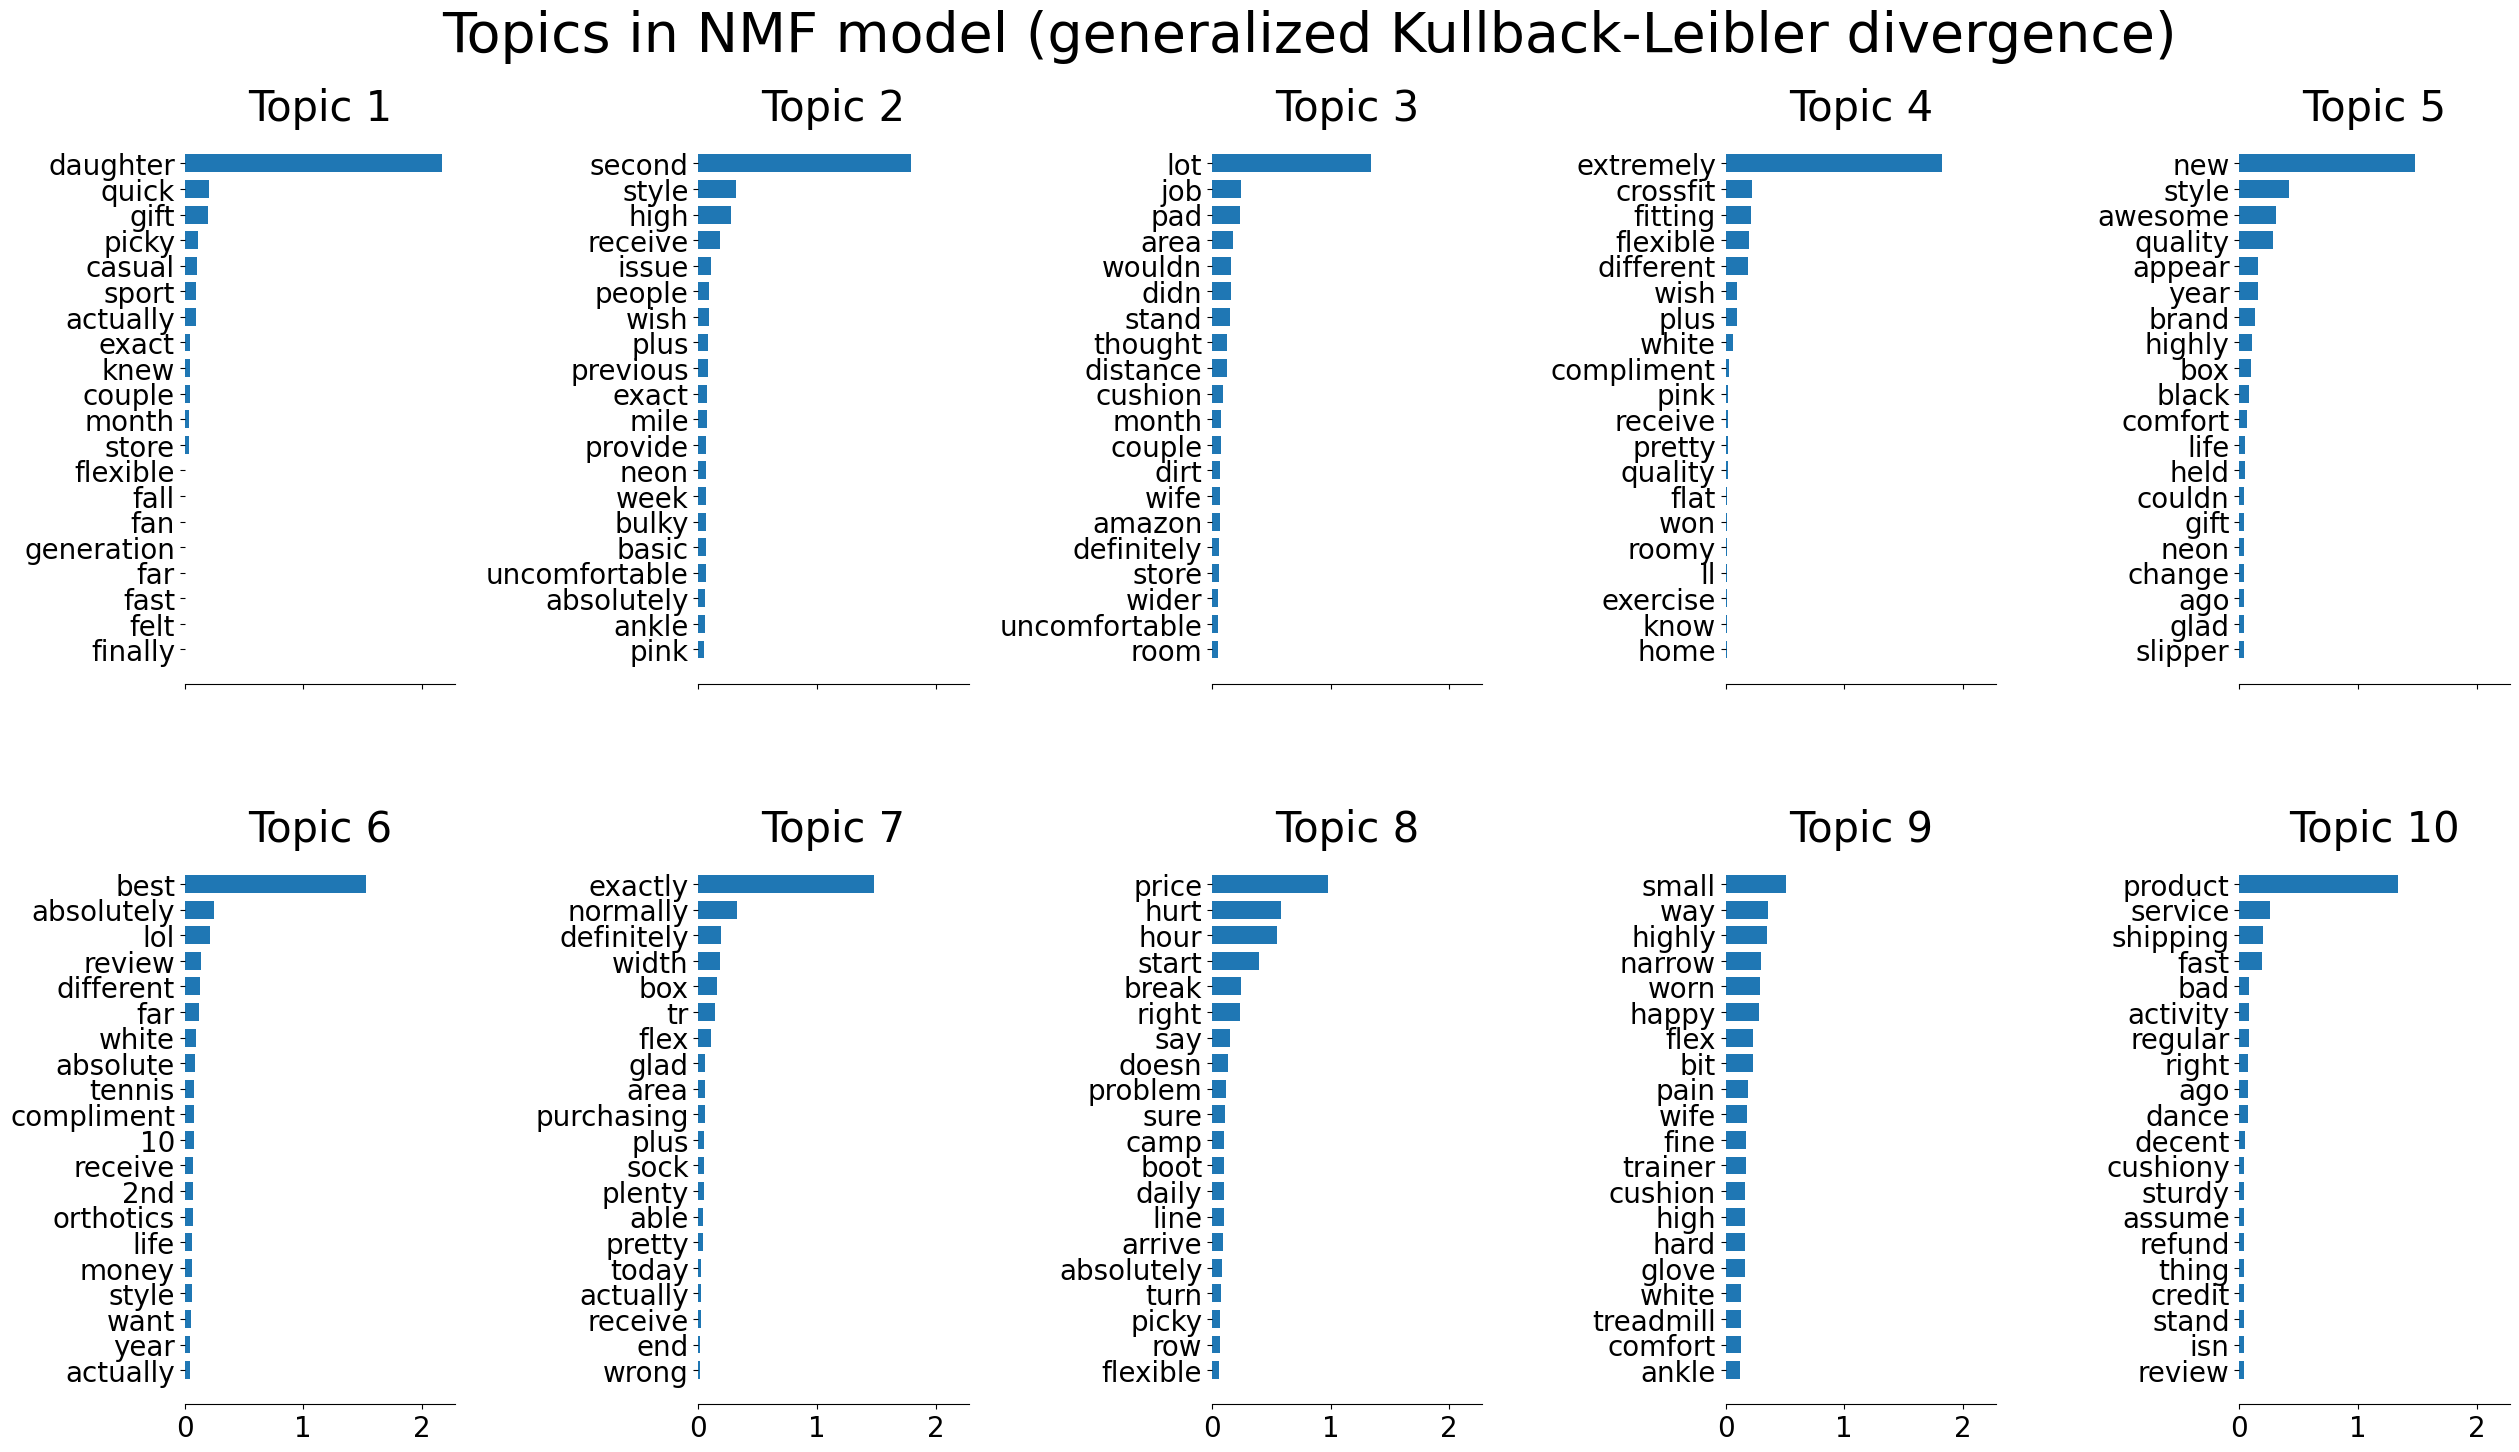

In [15]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

In [16]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


/Users/shy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:2308: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


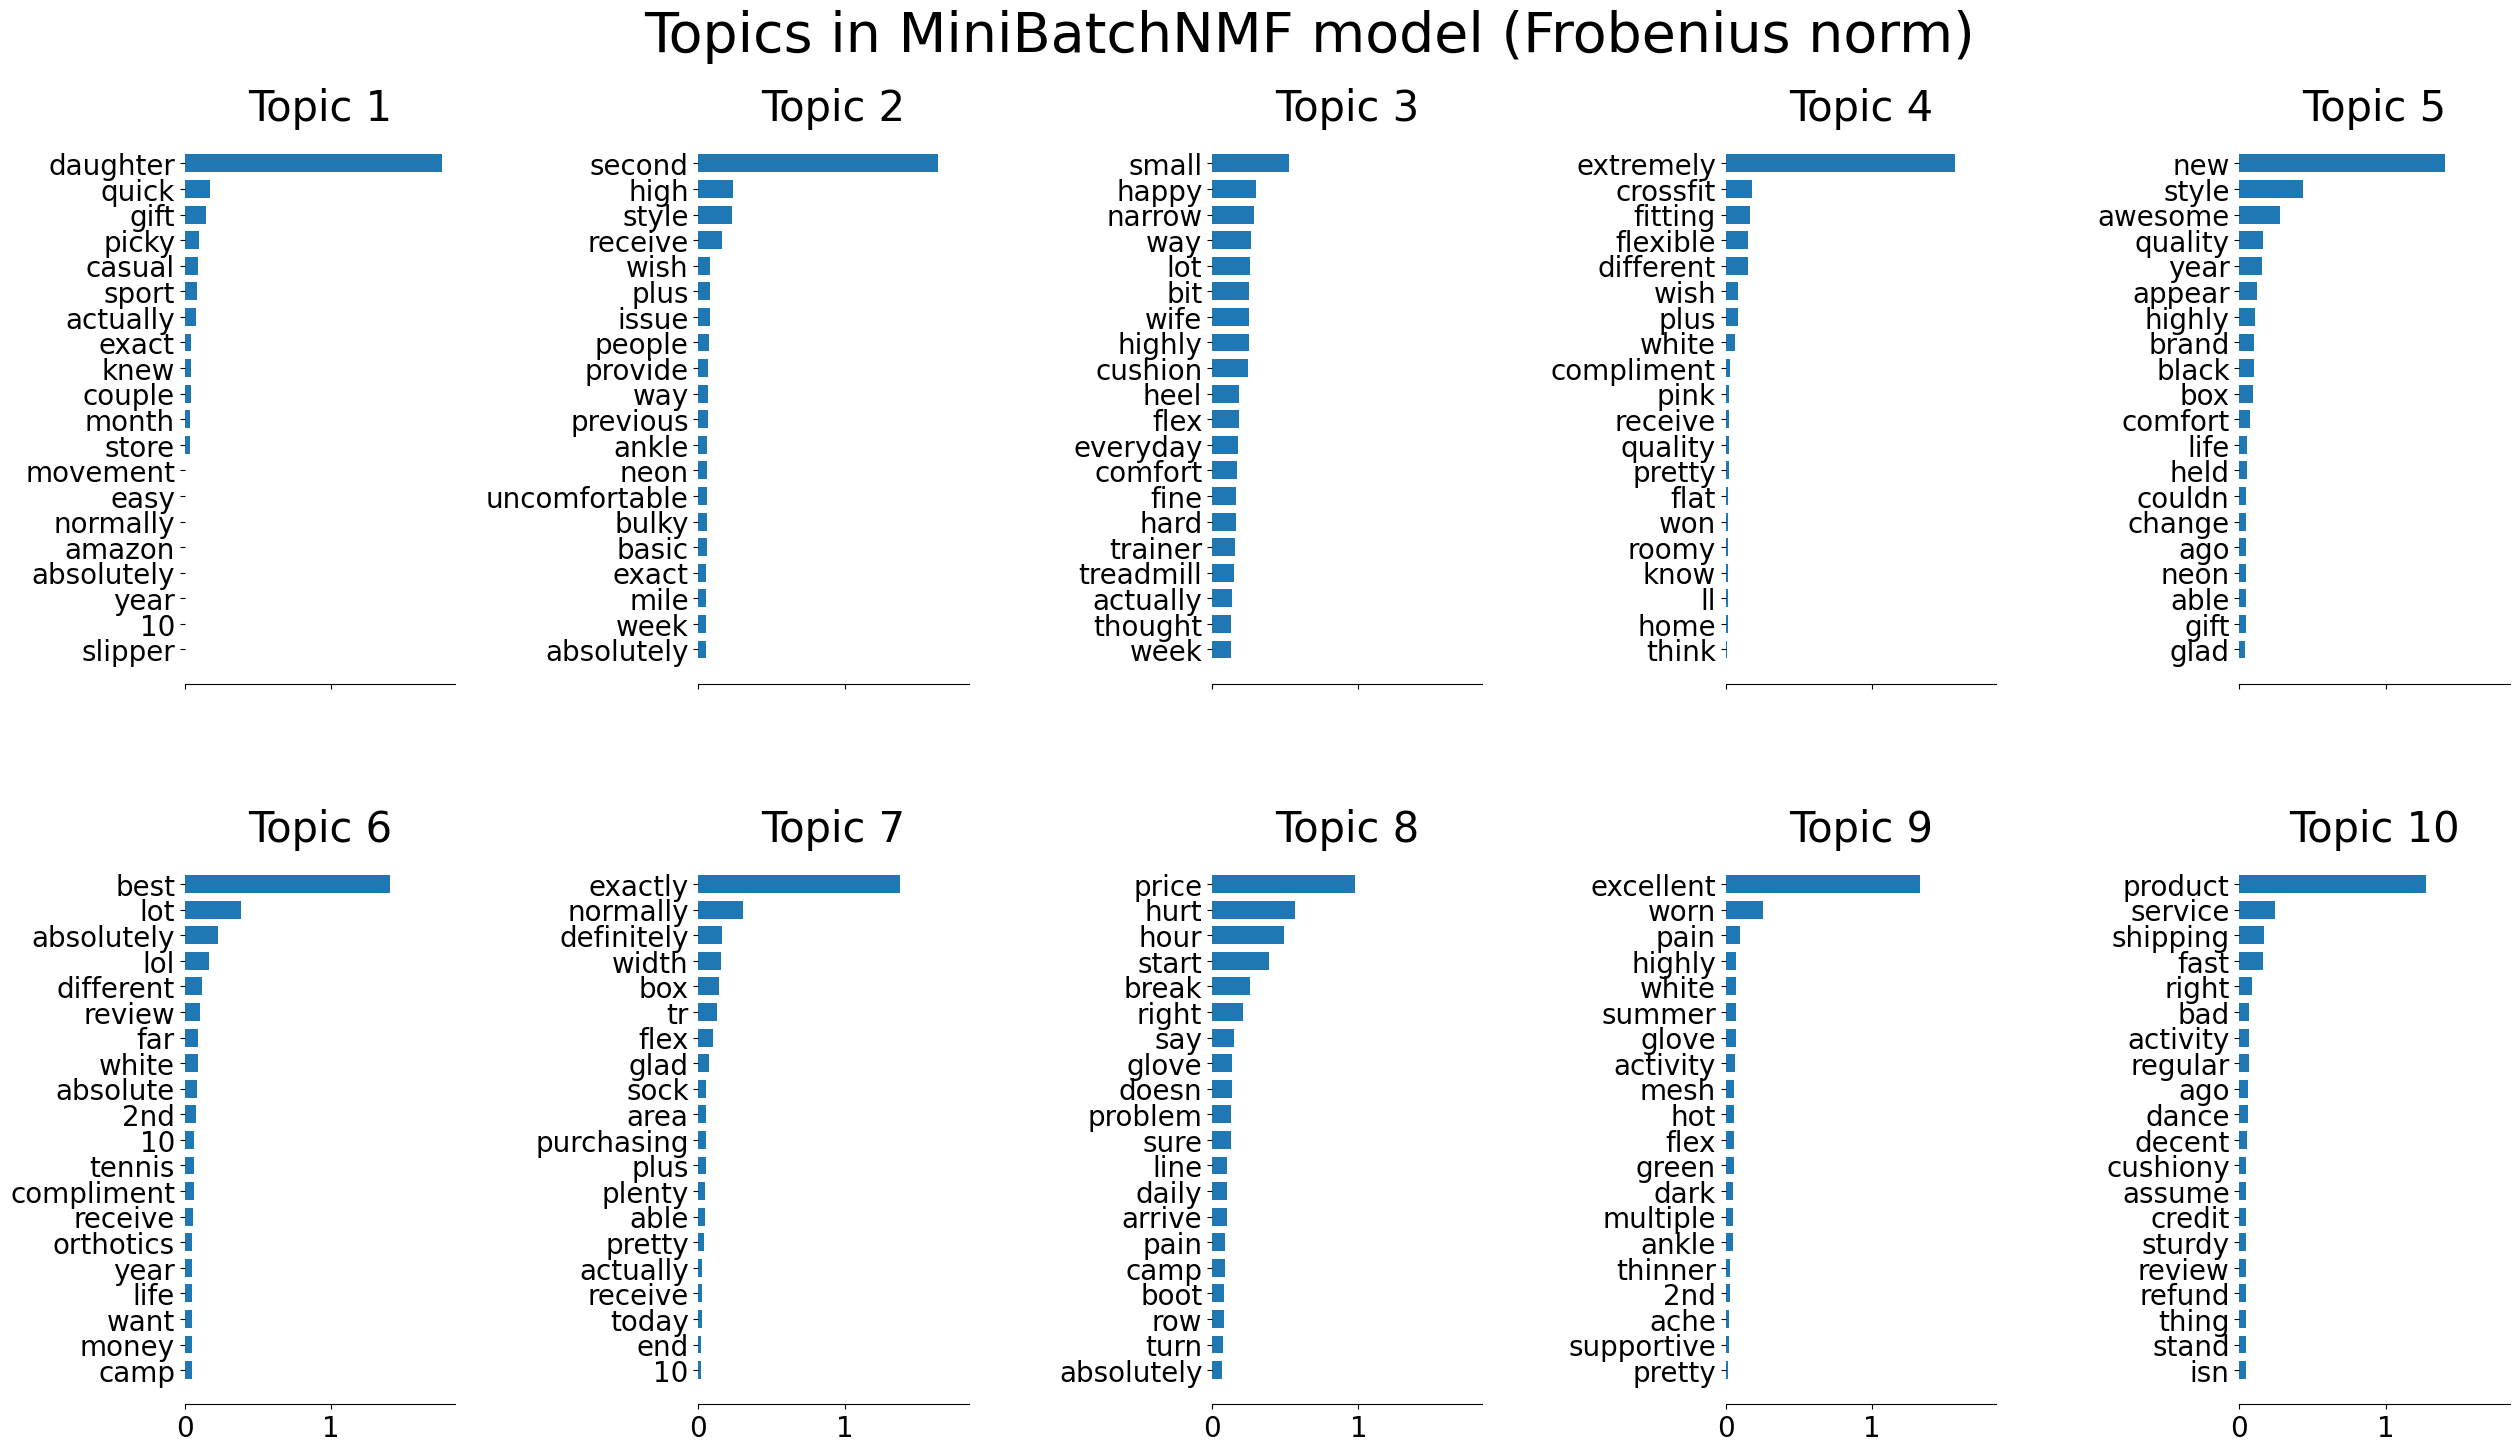

In [17]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

In [18]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


/Users/shy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:2308: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


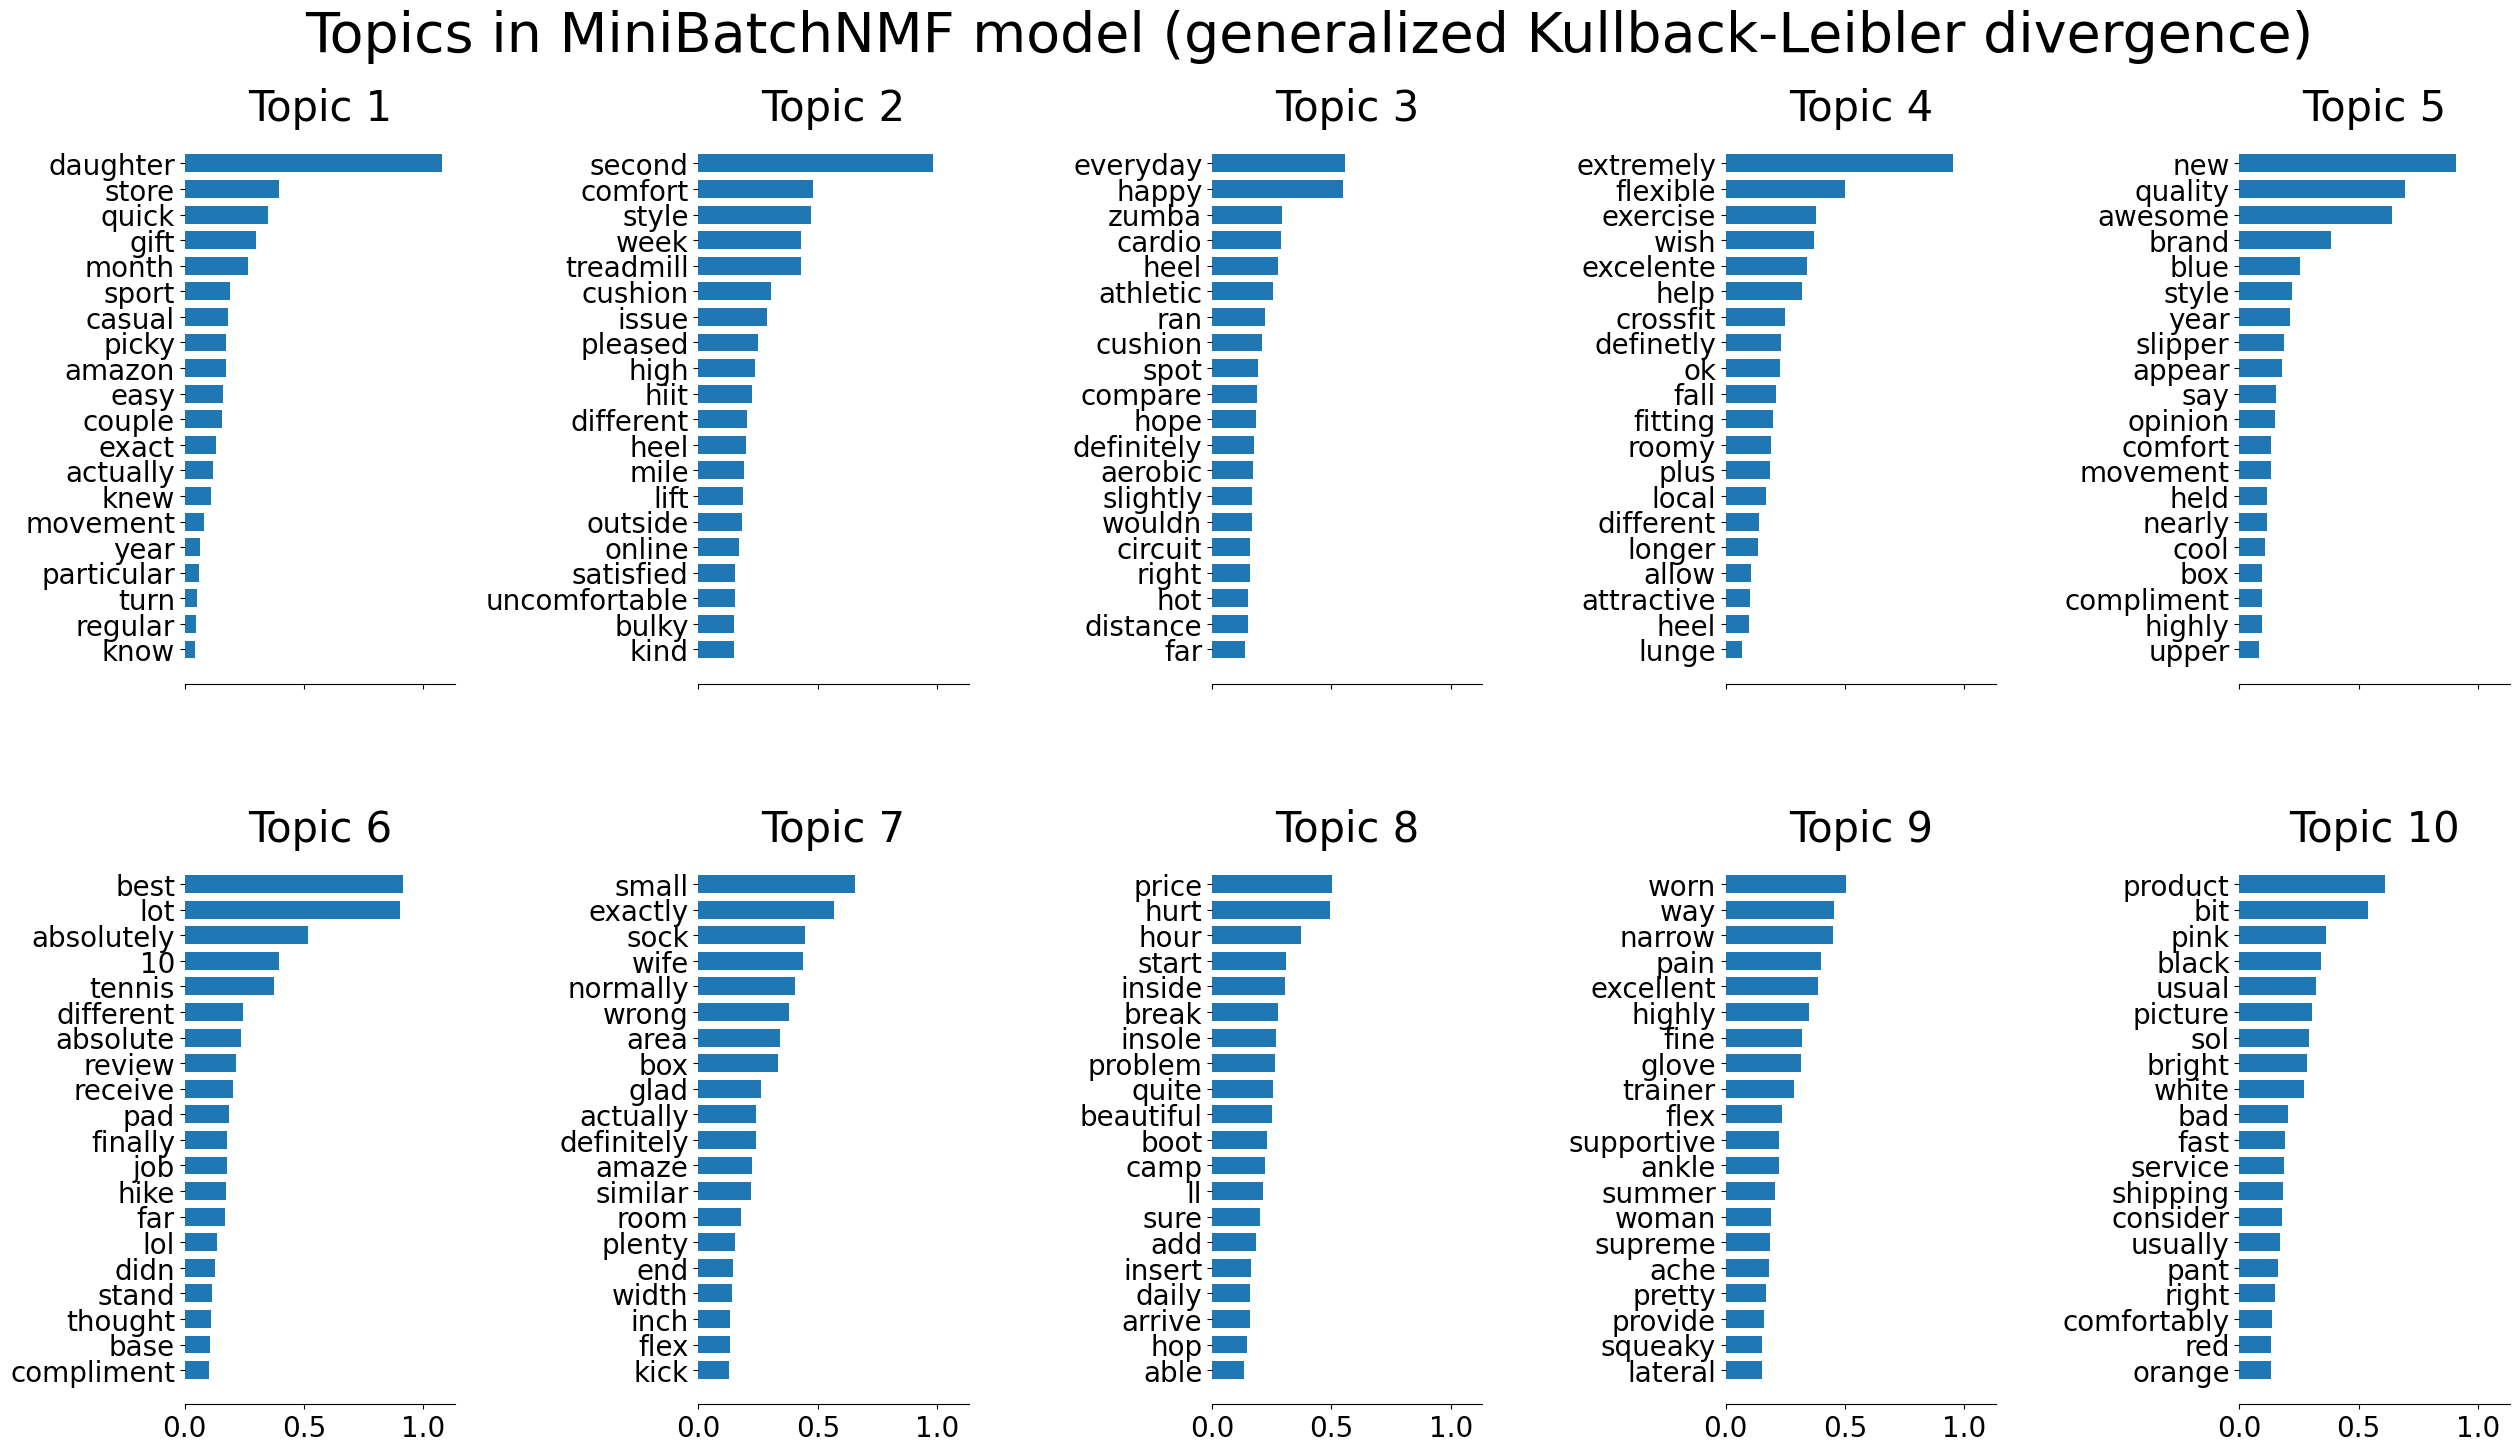

In [19]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

In [20]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'able',
 'absolutely',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'ache',
 'achilles',
 'activity',
 'actually',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'anymore',
 'apart',
 'arch',
 'area',
 'arose',
 'arrive',
 'artculo',
 'asics',
 'athletic',
 'attention',
 'away',
 'awesome',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'best',
 'big',
 'bit',
 'black',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bought',
 'box',
 'boxier',
 'brand',
 'break',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'ca

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


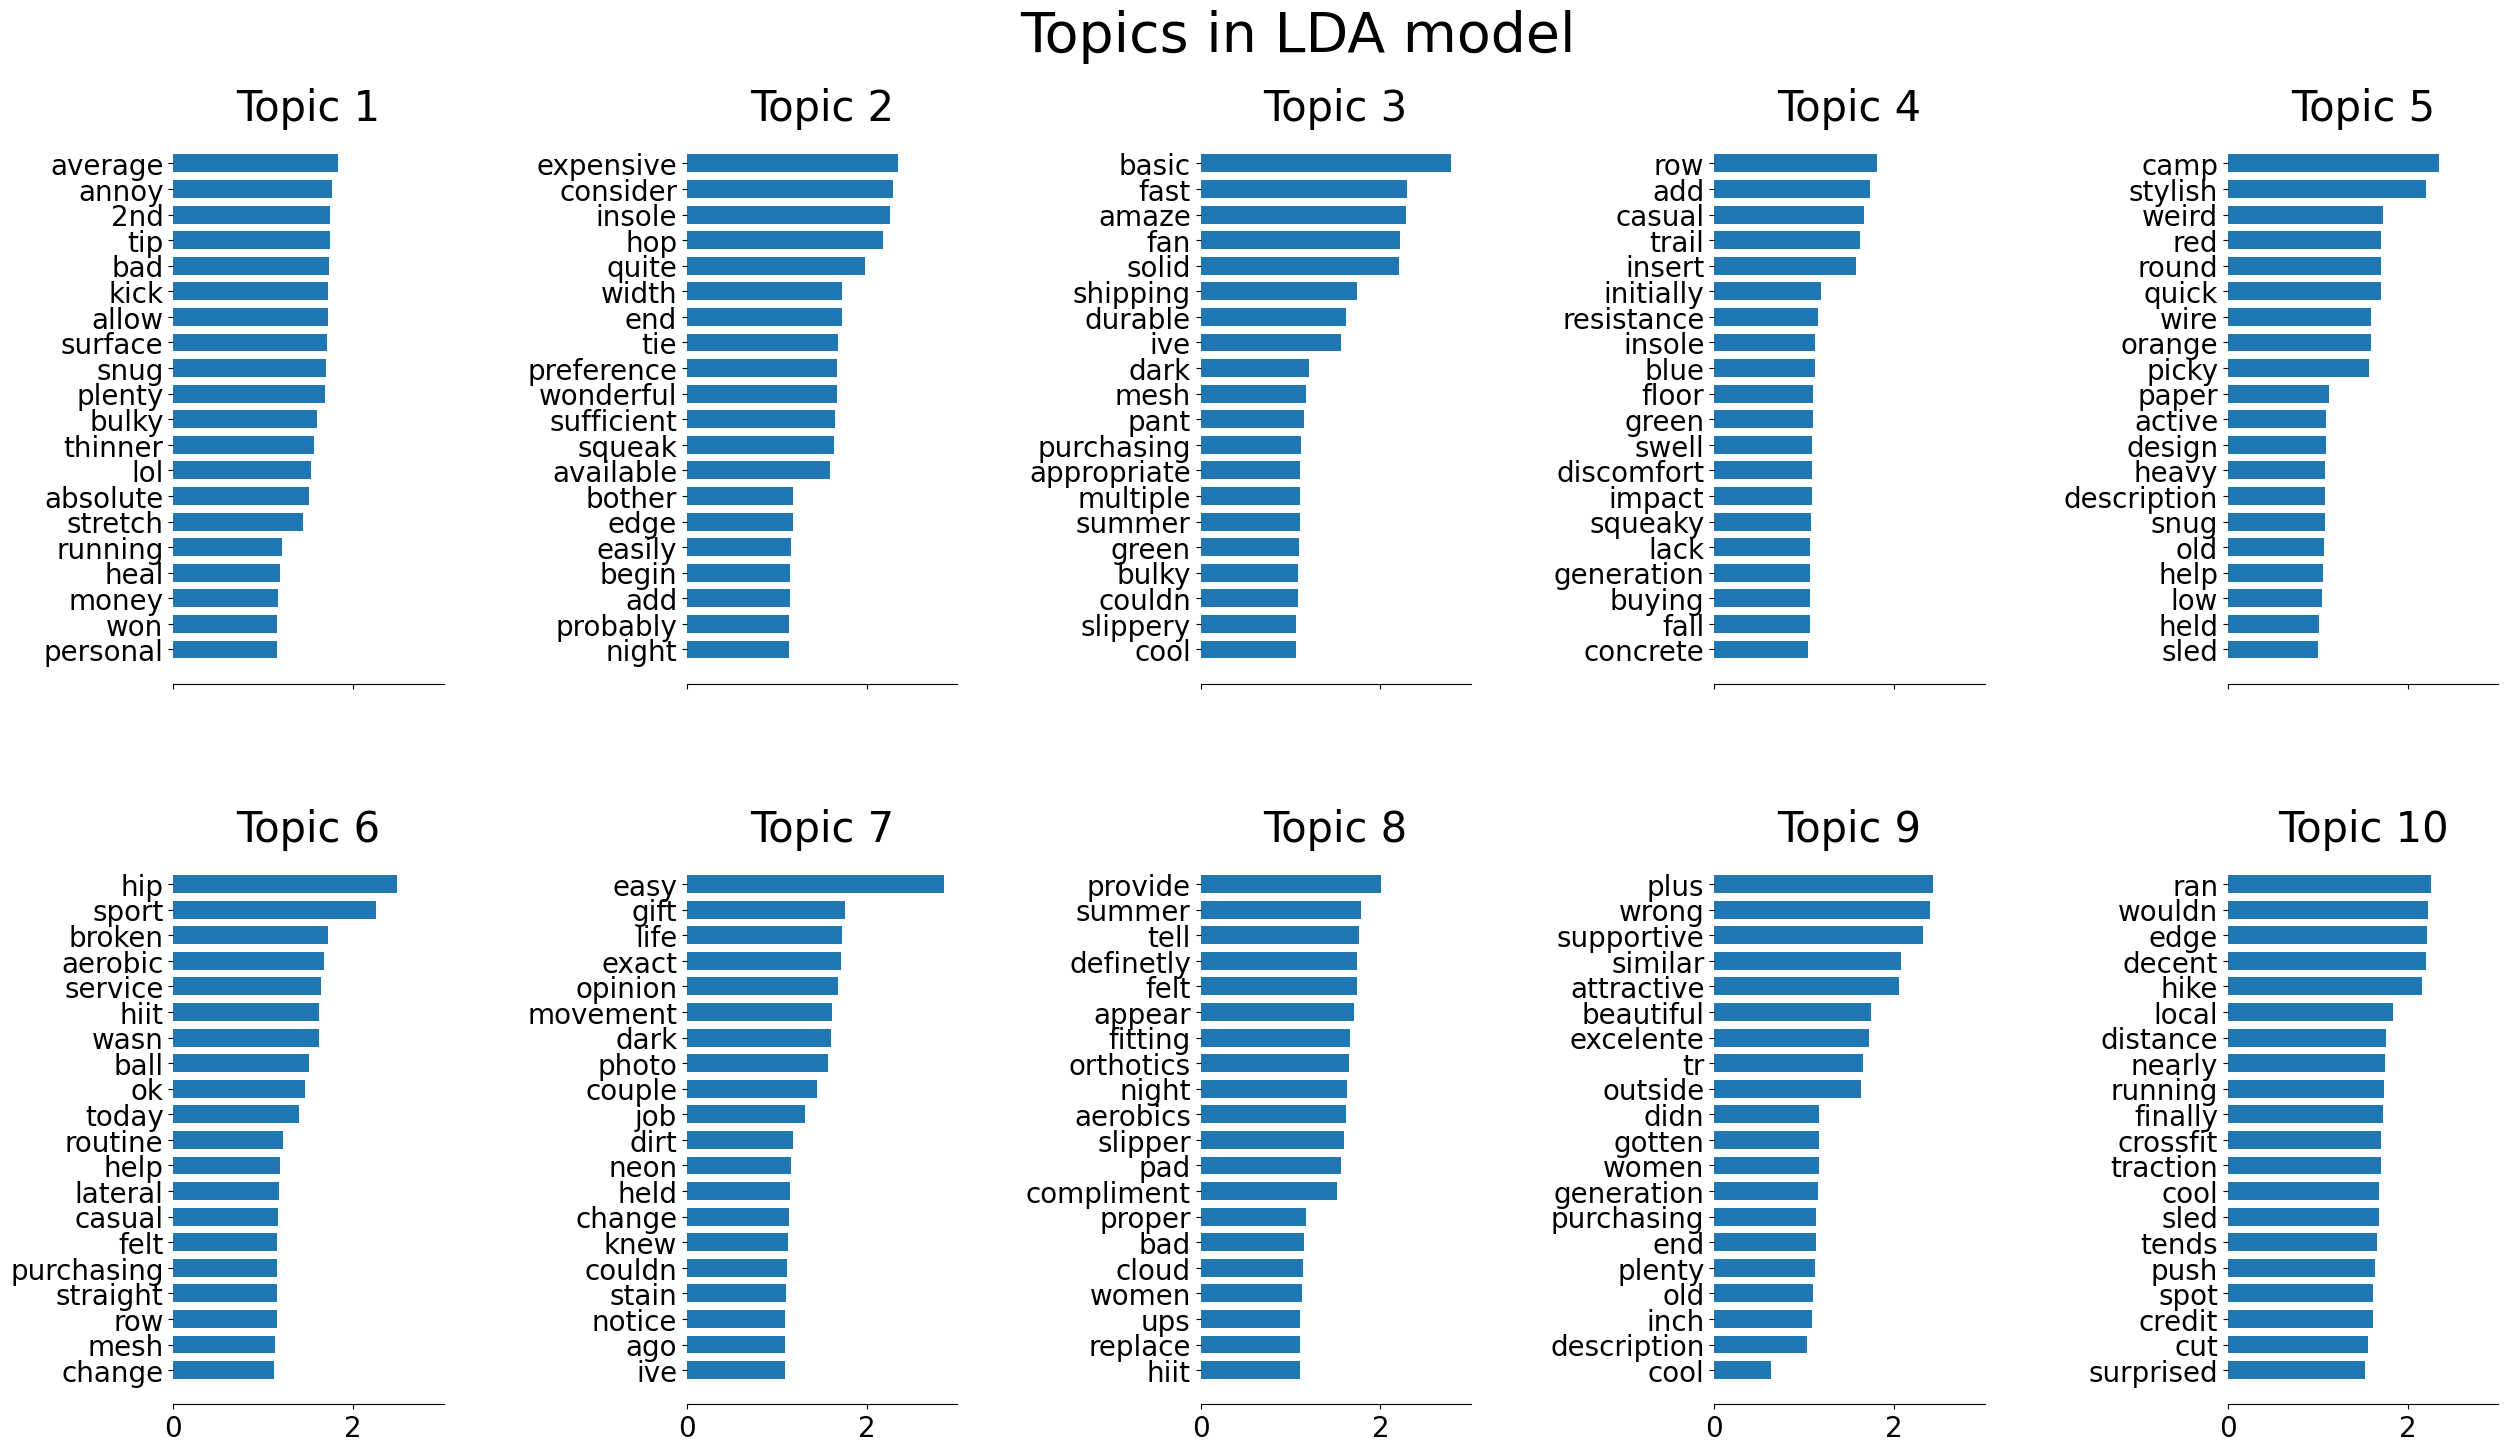

In [21]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [22]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : try them on in a store before buying online so i knew they'd fit good overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far they be really light and comfortable most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc highly satisfied with this purchase
60 : glad i read the review and order a half size too big these be light weight i work out in them last night and have a great work out they be very comfortable i would recommend these to anyone i be a beach body coach and these be now my new favorite shoe to work out in i feel like i be walk in slipper when i wear these shoe they be so comfortable i love them so much i never buy myself anything nice and for christmas get an amazon gift card and use it to buy myself these sneaker and they be so awesome i really do love them and have be tell all my friend about them get these shoe
62 : i love these 

In [31]:
lda.transform(tf_vectorizer.transform([data_samples[84]]))

array([[0.01666733, 0.01666811, 0.01666765, 0.01666868, 0.01666749,
        0.84999   , 0.01666741, 0.01666835, 0.01666757, 0.01666741]])

In [30]:
data_samples[84]

"i bought these for gym training - weight class and dance class body jam zumba - and really want to like them since i love the color and the light weight feel but when i work out high impact my toe tingle go numb and cramped because the toe bed be very narrow also there wasn't enough cushion for me when do lunge the ball of my foot hurt can't return them because i wore them several time these might be fine for someone with a narrow foot"

In [49]:
from nltk import sent_tokenize


raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
raw_sentences = sent_tokenize(raw_reviews[337])

processed_sentences = raw_sentences[:]
processed_sentences = lowercasing(processed_sentences)
processed_sentences = punctuation_removal(processed_sentences)
processed_sentences = lemmatize(processed_sentences)

print(raw_sentences)
processed_sentences

['Comfortable and lightweight.', "Need a good training shoe that's also supportive and flexible.", 'I really like the fit, but had to get 1/2 size larger as this style in my size is too perfect from heel to toe.']


['comfortable and lightweight',
 "need a good training shoe that's also supportive and flexible",
 'i really like the fit but have to get 1/2 size large a this style in my size be too perfect from heel to toe']

In [43]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [50]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
for raw, processed in zip(raw_sentences, processed_sentences):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

Comfortable and lightweight. 
	 overall: 0.51 neutral: 0.38, No Topic

Need a good training shoe that's also supportive and flexible. 
	 overall: 0.72 neutral: 0.50, Topic 9: plus, wrong, supportive, similar, attractive, beautiful, excelente, tr, outside, didn

I really like the fit, but had to get 1/2 size larger as this style in my size is too perfect from heel to toe. 
	 overall: 0.83 neutral: 0.71, No Topic



In [29]:
lda.transform(tf_vectorizer.transform(["easy gift life"])).argmax()
topic_words[6]

['easy',
 'gift',
 'life',
 'exact',
 'opinion',
 'movement',
 'dark',
 'photo',
 'couple',
 'job']